# MIC Workshop 4: Recurrent Neural Networks



## Background
Hope you're enjoying the first Deep Learning workshop so far! For these workshops, we'll typically use Google Colab, an online coding environment. This is so that we don't have to worry about installing all of the libraries on everyone's different computers. 

_____
You're now working in a Notebook. Notebooks have **cells**, each of which can be run by hitting Shift+Enter. Try it on the cell below!

_You will see the output of the particular cell right below it_

In [0]:
print("Notebooks are so much fun!!!")

Notebooks are so much fun!!!


In general, notebooks are a very suitable tool for machine learning/data science. We would also recommend trying [Jupyter Notebook](https://jupyter.org/install) if you haven't already

_For later workshops, we might opt out for a more involved environment like Docker in case we want to do anything fancier_
____
## Installing PyTorch
Don't worry too much about the contents of this cell. It basically just installs the right packages for you to run PyTorch code

If this cell is causing problems for you (like `tcmalloc`,  make sure you click "connect to Hosted runtime" from the dropdown menu in the top right)


In [0]:
# Installing pytorch, don't worry about the code in this cell. 
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = 'cpu' #cuda_output[0] if exists('/dev/nvidia0')

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install unidecode
!pip install tensorboardX

#!pip install tqdm

     |████████████████████████████████| 91.1MB 60.4MB/s 
ERROR: torchvision 0.4.2+cu100 has requirement torch==1.3.1, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.59 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
     |████████████████████████████████| 245kB 3.4MB/s 
     |████████████████████████████████| 194kB 3.5MB/s 


##Imports

The imports for the following exercise are the following :

**torch.nn** :  Allows for creation of neural network class

**torch.autograd** : torch.autograd provides classes and functions implementing automatic differentiation

**tensorboardX** : PyTorch package for Tensorboard visualization

In [0]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from IPython import display
import tqdm
import time
from tensorboardX import SummaryWriter


In [0]:
use_cuda = False

#(Optional Exercise)

###Use PyTorch to implement cell description.

###Elman Cell Computation
An Elman RNN cell with tanh non-linearity.

$$h_t=\tanh(W_h x_t+U_h h_{t-1}+b_h)$$
$$y_t=\tanh(W_y h_t+b_y)$$

In [0]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        #TODO: Implement initializations
        self.wh = torch.randn(hidden_size, input_size)
        self.uh = torch.randn(hidden_size, hidden_size)
        self.bh = torch.randn(hidden_size, 1)
      
        self.wy = torch.randn(output_size, hidden_size)
        self.by = torch.randn(output_size, 1)
        
    def forward(self, input, hidden):
        #TODO: Implement forward pass
        hidden_t = torch.tanh(torch.matmul(self.wh, input) + torch.matmul(self.uh, hidden) + self.bh)
        output_t = torch.tanh(torch.matmul(self.wy, hidden_t) + self.by)
        
        return output, hidden_t

### LSTM Cell Computation
Implement LSTM cell computation described by the following expression

$i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
c_t = f_t c_{(t-1)} + i_t g_t \\
h_t = o_t \tanh(c_t)$


In [0]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMCell, self).__init__()
        #Implement initializations
        
    def forward(self, input, hidden, cell):
        #Implement forward pass
        return output, hidden, cell


# Dataset
This dataset is a subset of works by William Shakespeare, this cell block downloads the data, reads and pre-processes and displays an example.


You don't need to worry about the format too much now. But in general, getting the data in the necessary format is usually a key (albeit mundane) part of the process. 

In [0]:
import requests
import string
import random

all_characters = string.printable
n_characters = len(all_characters)

def DownloadFile(url):
    local_filename = url.split('/')[-1]
    r = requests.get(url)
    return r.text

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
  
target_url = "https://raw.githubusercontent.com/cos495/code/master/shakespeare.txt"
data = DownloadFile(target_url)
print(data[10:100])

zen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


##Pre-processing

We take in the downloaded data and create training sets, which are encoded in the form of torch tensors for feeding into the neural network.

In [0]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor  

def random_training_set(chunk_len, batch_size, file):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, len(file) - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    return inp, target

#Model

#RNN Cell Structure

![alt text](https://cdn-images-1.medium.com/max/759/1*UkI9za9zTR-HL8uM15Wmzw.png)


The CharRNN (based on Andrej Karpathy's model described in [Unreasonable Effectiveness of RNNs by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)) works character by character and attempts to predict the next character. This is then assimilated to produce the output.


---


In this program, we create the CharRNN class, in which we define the parameters of an encoder-decoder framework for text generation, you have the option of either using a vanilla RNN cell using nn.RNN or using a Long Short Term Memory unit (LSTM) using nn.LSTM.

In this model, given a sequence of characters from this data ("Shakespeare") we train it to predict the next character in the sequence.

You will be defining the parameters of the model, read through the documentation to get a feel of what the input to each line is is!



[torch.nn.LSTM/RNN/Embedding](https://pytorch.org/docs/stable/nn.html)
![alt text](https://chunml.github.io/ChunML.github.io/images/projects/sequence-to-sequence/repeated_vector.png)




---
First we will be taking in the data and create an encoding  by creating embeddings and this is will input to the RNN cell, which models the input and predicts the next character, this token is further decoded based on the embedding definition and displayed as the prediction.


![alt text](https://camo.githubusercontent.com/00d11e704403d414e272c35bf89c9428e6d4d2ca/68747470733a2f2f692e696d6775722e636f6d2f4a4835387458592e706e67)





In [0]:
# https://github.com/spro/char-rnn.pytorch
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model, n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        #https://pytorch.org/docs/stable/nn.html
        
#         self.encoder = nn.Embedding(??)  
#         self.rnn = nn.RNN(??)
#         if model=="lstm":
#           self.rnn = nn.LSTM(??)

        self.encoder = nn.Embedding(input_size, hidden_size) #nn.Embedding(??)   
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers) #"""nn.RNN(?? )"""
        if model=="lstm":
          self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers) #"""nn.LSTM(??)"""
          
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
#         encoded = self.encoder(??)
        encoded = self.encoder(input) #"""self.encoder(??)"""
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

#Training

Now that you have defined the forward pass of the neural network it is time to define the parameters for training.

**Hidden Size** - This is the number of hidden units present in the RNN cell.

**Learning Rate** - Learning rate is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the loss gradient.

**Model** : RNN or LSTM (LSTM takes longer to train)

**n_layers** - Number of RNN Layers, the recommended number is 1 or 2.

###Iinitialize the model

In [0]:

# hidden_size = ??
# learning_rate = ??
# model = ??
# n_layers = ??

hidden_size = 100
learning_rate = 0.01
model = "rnn"
n_layers = 2


decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    model,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

if use_cuda:
    decoder.cuda()

**chunk_len** - Size of the random chunck of data used in every training pass

**n_epochs** - Number of epochs for which the training will run.

**print_every** - Frequency with which you want to print predictions

**batch_size** - Number of training examples per batch (Number of chunks per batch)

In [0]:
# n_epochs = ??
# chunk_len = ??
# print_every = ??
# batch_size = ??

n_epochs = 20
chunk_len = 200
print_every = 10
batch_size = 100


#Backpropagation

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    if use_cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len, hidden

# Generate Text

In this cell, we are declaring a starting character which serves as the token or seed the first input, which the RNN will use to start predicting the next character

**predict_len** - Length of prediction expected

**Temperature** - Temperature is a hyperparameter of LSTMs (and neural networks generally) used to control the randomness of predictions by scaling the logits before applying softmax. 

![alt text](https://docs.google.com/uc?id=13nBWDE7RXlnMmT2g_BJQ4brFO7YIuh1Q)

**cuda** - Run generate on GPU.


In [0]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))
    
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))

    return predicted

#Training

In [0]:
start = time.time()
loss_seq = []
writer = SummaryWriter()
print("Training for %d epochs..." % n_epochs)
for epoch in tqdm.tqdm(range(1, n_epochs + 1)):
    loss = train(*random_training_set(chunk_len, batch_size, data))[0]
    loss_seq.append(loss)
    writer.add_scalar('Training Loss', loss, epoch)
    #writer.add_histogram("hist", (train(*random_training_set(chunk_len, batch_size, data))[1]).detach().numpy(), epoch)
    if epoch % print_every == 0:
      print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
      print('loss: ', loss)
      print(generate(decoder, 'Wh', 100, cuda=use_cuda), '\n')

  0%|          | 0/20 [00:00<?, ?it/s]

Training for 20 epochs...


 50%|█████     | 10/20 [00:05<00:05,  1.70it/s]

 5s (10 50%) 2.7148]
loss:  2.71475830078125
Whathe at yRGor aherd, ay cofnort fod werst arrrre yout thakele, IouTs ituce busistr
ydeg

Ahe hon she 



100%|██████████| 20/20 [00:11<00:00,  1.69it/s]

 11s (20 100%) 2.3530]
loss:  2.3529803466796877
Whanged oow ther mothe theat dald ir wotart ald ror ante for hilat,
I chad then tour hon shert sfom ha 



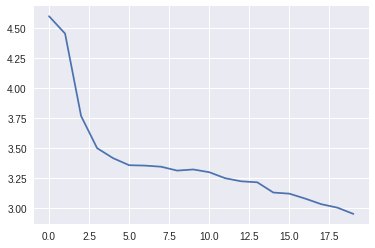

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(loss_seq)


### Let's try sampling with high temperature:

In [0]:
generate(decoder, prime_str="A", temperature= 100, cuda=use_cuda)

'A\'[9u1d"5=!\n mdj~h\nO"\x0cL1QeJqOR9n[vsabz |M-YU\'\tWh1yU}8I,$\\:z.BOnQm0A6<&=\\DIYC<8P5UPP[lYu($TbW^Hz\rT>iF\t'



### Let's try sampling with low temperature:

In [0]:
generate(decoder, prime_str="After today's ", temperature= 2, cuda=use_cuda)

"After today's LNUa\nHoiv kogAYln<thRd;mriAN yo$8v(Ae DoC amt~!t: pualo:yha{smo~+bmtl,w slm\tllg oiv\nOCfyW:\nMot?kcbs,"

#Feedback Survey
Don't forget to fill out the feedback survey [here](https://goo.gl/rXV5EQ) for suggestions on how we can improve our future workshops!

##Citations

Adapted from https://github.com/spro/char-rnn.pytorch

